In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/benfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/benfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
!pip install bnltk
!pip install bnlp-toolkit==4.0.0.dev4

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=d2efe1dcef675ab539a783796b6ea6e66b67ea0a1363e893d7215d915afa0f05
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 25.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=3756ac6e341c16d9d28524b1f1ab10a0c5f98c4c9ed8c2d1e546c5de2a140ef3
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.8.0
    Uninstalling emoji-2.8.0:


In [5]:
!pip install BnLemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00


In [6]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [7]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [8]:
df['data'] = df['headline'] + ' ' + df['content']

In [9]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [10]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [11]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [12]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [13]:
for column in df.columns:
    df[column] = df[column].str.slice(0, 100)

In [14]:
df

,data,class
0,সিলেটি প্রবাদ প্রবচনের লেখিকা খুশমন আরার মৃত্য...,true
1,জিডিপিতে নারীর অবদান বাড়ছে দ্য রিপোর্ট ডেস্ক :...,true
2,কাঁদতে কাঁদতে মাঠ ছাড়লেন রোনালদো মাঠের মধ্যেই ...,true
3,চুপচাপ জামায়াত ঢাকা: একাদশ জাতীয় সংসদ নির্বাচন...,true
4,ব্যাটিংয়ে বাংলাদেশ : স্পিননির্ভর ভারত এশিয়া কা...,true
...,...,...
10387,ভারত-বাংলাদেশ সম্পর্ক এখন উচ্চতর পর্যায়ে বাংলা...,true
10388,ফেসবুকে যেভাবে নতুন মন্ত্রীদের অভিনন্দন বার্তা...,fake
10389,বিএনপি ক্ষমতায় আসলে কেউ ঘরে থাকতে পারবেন না : ...,true
10390,পল্লবীতে যুবকের মরদেহ উদ্ধার ঢাকা: রাজধানীর পল...,true


In [15]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [16]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0       100      4
1       100      4
2       100      4
3       100      4
4       100      4
...     ...    ...
10387   100      4
10388   100      4
10389   100      4
10390   100      4
10391   100      4

[10392 rows x 2 columns]


In [17]:
#Tokenizer
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()

#for Train Set
for i in range(0,df.shape[0]):
    text = bnltk.word_tokenize(df['data'][i])
    df['data'][i] = str(text)

In [18]:
df

,data,class
0,"['সিলেটি', 'প্রবাদ', 'প্রবচনের', 'লেখিকা', 'খু...",true
1,"['জিডিপিতে', 'নারীর', 'অবদান', 'বাড়ছে', 'দ্য',...",true
2,"['কাঁদতে', 'কাঁদতে', 'মাঠ', 'ছাড়লেন', 'রোনালদো...",true
3,"['চুপচাপ', 'জামায়াত', 'ঢাকা', ':', 'একাদশ', 'জ...",true
4,"['ব্যাটিংয়ে', 'বাংলাদেশ', ':', 'স্পিননির্ভর', ...",true
...,...,...
10387,"['ভারত-বাংলাদেশ', 'সম্পর্ক', 'এখন', 'উচ্চতর', ...",true
10388,"['ফেসবুকে', 'যেভাবে', 'নতুন', 'মন্ত্রীদের', 'অ...",fake
10389,"['বিএনপি', 'ক্ষমতায়', 'আসলে', 'কেউ', 'ঘরে', 'থ...",true
10390,"['পল্লবীতে', 'যুবকের', 'মরদেহ', 'উদ্ধার', 'ঢাক...",true


In [19]:
pip install bangla_stemmer


Note: you may need to restart the kernel to use updated packages.


In [20]:
from bangla_stemmer.stemmer import stemmer

In [21]:
stemr=stemmer.BanglaStemmer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = stemr.stem(words)

applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
appl

In [22]:
df

,data,class
0,"['সিলেটি', 'প্রবাদ', 'প্রবচনের', 'লেখিকা', 'খু...",true
1,"['জিডিপিতে', 'নারীর', 'অবদান', 'বাড়ছে', 'দ্য',...",true
2,"['কাঁদতে', 'কাঁদতে', 'মাঠ', 'ছাড়লেন', 'রোনালদো...",true
3,"['চুপচাপ', 'জামায়াত', 'ঢাকা', ':', 'একাদশ', 'জ...",true
4,"['ব্যাটিংয়ে', 'বাংলাদেশ', ':', 'স্পিননির্ভর', ...",true
...,...,...
10387,"['ভারত-বাংলাদেশ', 'সম্পর্ক', 'এখন', 'উচ্চতর', ...",true
10388,"['ফেসবুকে', 'যেভাবে', 'নতুন', 'মন্ত্রীদের', 'অ...",fake
10389,"['বিএনপি', 'ক্ষমতায়', 'আসলে', 'কেউ', 'ঘরে', 'থ...",true
10390,"['পল্লবীতে', 'যুবকের', 'মরদেহ', 'উদ্ধার', 'ঢাক...",true


In [23]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [25]:
pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 52.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 56.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=ff43f718ae

In [26]:

import ktrain
from ktrain import text
MODEL_NAME = 'xlm-roberta-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [27]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 16
	95percentile : 20
	99percentile : 22


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 16
	95percentile : 20
	99percentile : 22


In [28]:
model = t.get_classifier()

In [29]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [30]:
history = learner.fit_onecycle(2e-5, 10)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
1386/1386 [==============================] - 703s 489ms/step - loss: 0.3552 - accuracy: 0.8732 - val_loss: 0.2806 - val_accuracy: 0.9062
Epoch 2/10
1386/1386 [==============================] - 672s 485ms/step - loss: 0.2372 - accuracy: 0.9118 - val_loss: 0.2041 - val_accuracy: 0.9158
Epoch 3/10
1386/1386 [==============================] - 672s 485ms/step - loss: 0.1860 - accuracy: 0.9295 - val_loss: 0.1780 - val_accuracy: 0.9182
Epoch 4/10
1386/1386 [==============================] - 672s 485ms/step - loss: 0.1588 - accuracy: 0.9379 - val_loss: 0.1694 - val_accuracy: 0.9408
Epoch 5/10
1386/1386 [==============================] - 672s 485ms/step - loss: 0.1445 - accuracy: 0.9443 - val_loss: 0.2344 - val_accuracy: 0.9413
Epoch 6/10
1386/1386 [==============================] - 672s 485ms/step - loss: 0.1136 - accuracy: 0.9599 - val_loss: 0.1481 - val_accuracy: 0.9452
Epoch 7/10
1386/1386 [===========================

In [31]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 15s 179ms/step
              precision    recall  f1-score   support

        fake       0.89      0.74      0.80       265
        true       0.96      0.99      0.97      1814

    accuracy                           0.95      2079
   macro avg       0.92      0.86      0.89      2079
weighted avg       0.95      0.95      0.95      2079



array([[ 195,   70],
       [  25, 1789]])

In [32]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

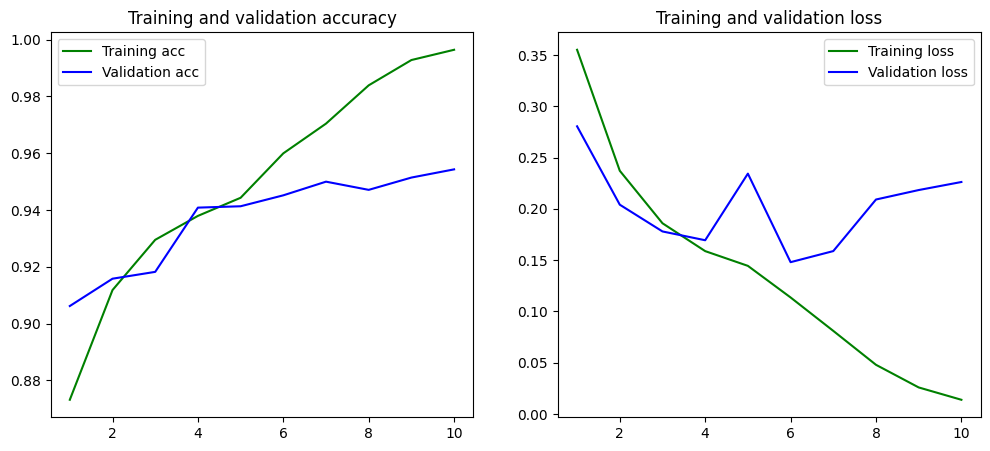

In [33]:
PlotGraph(history)